In [3]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *

from qiskit import Aer, IBMQ, assemble, execute, BasicAer, ClassicalRegister, QuantumRegister
from qiskit.quantum_info.operators import Operator
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_histogram
from qiskit.circuit import Gate, Parameter
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit.library.standard_gates import RYGate

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

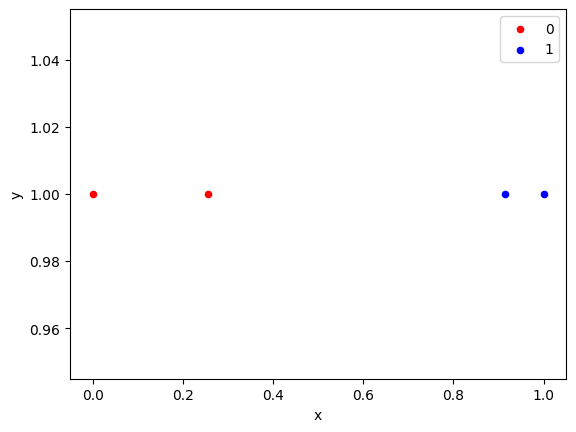

In [12]:
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt
from pandas import DataFrame
from math import log2, ceil, pi
import numpy as np
from sklearn import preprocessing



e0 = 0.001
N_size = 4
encoding_bits = int(ceil(log2(N_size)))
rescale_factor = 1


minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, rescale_factor))


# X_temp,y_circ = make_circles(n_samples=256, noise=0.025, random_state=5465)
# X_circ = minmax_scale.fit_transform(X_temp) # scale the data from 0-100


# df = DataFrame(dict(x=X_circ[:,0], y=X_circ[:,1], label=y_circ))
# colors = {0:'red', 1:'blue'}
# fig, ax = plt.subplots()
# grouped = df.groupby('label')
# for key, group in grouped:
#     group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
# plt.show()

X_temp,y_blobs = make_blobs(n_samples=N_size, n_features=1, random_state=4343, centers=2)
X_blobs = minmax_scale.fit_transform(X_temp) # scale the data from 0-100

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X_blobs[:,0], y=1, label=y_blobs))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [9]:
print(X_blobs)

[[  0.        ]
 [ 91.41239133]
 [100.        ]
 [ 25.5130207 ]]


In [83]:
vertex = range(X_blobs.shape[0])
print(vertex)
# step 1: build verteces and edges to make graph: G = (V,E)
# step 2: build the W matrix which is symmetric using RBF_kernel and remove the 1's across the diagonal
# step 3: buld D which the sum across axis=1 
# step 4: build laplacian, L = D-W
# step 5: normalize laplacian, L_s = D^(-1/2)*L*D^(-1/2)


range(0, 8)


In [38]:
# set up the initial space
# n = log2(N), where N is dataset size
# t = n + round up(2 + log2(1/2*e0) where e0 is the error rate of phase estimation, we will choose e0 = 0.001

def unitary_in(qc,t,n):
    # entangle the states
    for i in range(n):
        qc.h(t+i)
        qc.cx(t+i,t+n+i)

def unitary_phase_estimation(qc,t,n):
    for i in range(t):
        qc.h(i)
    repetitions = 1
    for counting_qubit in range(t):
        for i in range(repetitions):
            qc.cp(pi/4, counting_qubit, t); # controlled-T
        repetitions *= 2

def NormalizedLaplaceTransform(W):
    # print(f"W orginial: {W}")
    diag_elements = np.diag(np.diag(W))
    W = W-diag_elements
    # print(f"W with diagonals as zero:{W}")
    diagment = np.sum(W,axis=1)
    D=np.diag(diagment)
    # print(f"D:{D}")
    L = D-W
    # print(f"L:{L}")
    D_sqrt = np.sqrt(np.linalg.inv(D))
    # print(f"D_sqrt:{D_sqrt}")
    l_norm = np.matmul(D_sqrt,np.matmul(L,D_sqrt))
    # print(f"l_norm:{l_norm}")
    return l_norm

def get_adjacency_and_weight_matrix(raw_data, n_nearest_neighbors):
    n = len(raw_data)
    
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=n_nearest_neighbors, algorithm='auto').fit(raw_data)
    distances, indices = nbrs.kneighbors(raw_data)

    from sklearn.metrics.pairwise import rbf_kernel
    rbf = rbf_kernel(raw_data) # input must be np.array

    # only add weights if indices correspond to a connection
    weight_matrix = np.zeros((n,n))
    for i in range(len(indices)):
        for j in indices[i]:
            weight_matrix[i,j] = rbf[i][j]
    
    adjacency = nbrs.kneighbors_graph(raw_data).toarray()
    return adjacency, weight_matrix

def get_binary_number(x,n):
    return format(x, 'b').zfill(n)

##########################################################################################
##########################################################################################

def quantum_circuit(circuit, qubits, image_array, row):
    ###### NNNEEEEEDDDD TOOOOO FIXXXXXX THIISSSSSSS ###############
    # changed: encoding_bits,
    circuit.h(np.arange(qubits-1))

    for col in range(image_array.shape[0]):
        control_state = get_binary_number(col,encoding_bits)

        RYj = Operator(RYGate(pi/N_size*image_array[col]).control(encoding_bits, label = 'Pixel '+str(col), ctrl_state=control_state))
        RYi = Operator(RYGate(-pi/N_size*image_array[row]).control(encoding_bits, label = 'Pixel '+str(row), ctrl_state=control_state))

        circuit.append(RYi.compose(RYj), range(qubits))
    circuit.measure(range(qubits), range(qubits))
    return circuit


def measure_circuit(qde, backend, n_shots):
    job = backend.run(transpile(qde, backend), shots=n_shots)
    counts = job.result().get_counts()
    return counts


def retrieve_matrix_from_measurements(qubits, counts):
    measurements = np.array([0 for i in range(len(counts))])
    states_list = [0 for i in range(len(counts))]
    measurements, states_list = obtain_measurements_and_states_from_counts(counts, measurements, states_list)
    prob_array = obtain_probability_array(measurements, states_list, qubits)
    retrieved_image = np.arccos(np.sqrt(prob_array))*512/pi
    return retrieved_image


def obtain_measurements_and_states_from_counts(counts, measure_array, states_array):
    num = 0
    for bitstring, measure in counts.items():
        measure_array[num] = measure
        states_array[num] = int(bitstring,2)
        num += 1
    return measure_array, states_array


def obtain_probability_array(measure_array, states_array, qubits):
    index = np.argsort(states_array)
    measure_array = measure_array[index]
    prob_array = measure_array*(1/measure_array.sum())
    prob_array = check_numbers((2**(qubits-1))*prob_array[:2**(qubits-1)])
    return prob_array


##########################################################################################
##########################################################################################

def compute_edges(matrix):
    edges = [] # Initialize the list
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]): # for every column and row, do
            if matrix[i][j]!=0 and i!=j: # Except when the values of the adj matrix are 0
                edges.append((i, j)) # Append the value of the column and row
    return edges

def compute_laplacian(data, data_size, k_clusters):
    # initialize circuit
    n = ceil(log2(data_size))
    t = n + int(ceil(2 + log2(1/(2*e0))))
    user_selected_d = n
    
    # print(t+n+n)
    # must be t+n+n qubits
    qubits = t+n+n
    # qc = QuantumCircuit(qubits,qubits)
    
    adjacency, weight_matrix = get_adjacency_and_weight_matrix(data, user_selected_d)

    normalized_laplacian = NormalizedLaplaceTransform(weight_matrix)/(2*user_selected_d) # just to get eigenvalues from [0,1], doesn't change eigenvectors

    print(f"normalized_laplacian:{normalized_laplacian}")

    # print(laplacian)
    from numpy.linalg import eig
    # print("verify laplacian has eigenvalues 0 <= lambda")
    
    print(f"eig(laplacian):{eig(normalized_laplacian)}")

    return normalized_laplacian


In [42]:
N = len(X_blobs)
n = ceil(log2(N))
user_selected_d = n
normalized_laplacian = compute_laplacian(X_blobs, N, k_clusters=2)

normalized_laplacian:[[ 0.25  0.    0.   -0.25]
 [ 0.    0.25 -0.25  0.  ]
 [ 0.   -0.25  0.25  0.  ]
 [-0.25  0.    0.    0.25]]
eig(laplacian):(array([0.5, 0. , 0.5, 0. ]), array([[ 0.70710678,  0.70710678,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.70710678,  0.70710678],
       [ 0.        ,  0.        ,  0.70710678,  0.70710678],
       [-0.70710678,  0.70710678,  0.        ,  0.        ]]))


In [44]:
"""
Get d smallest eigenvalues
"""
import scipy.sparse.linalg as sla
eigenvalues, eigenvectors = sla.eigs(normalized_laplacian, user_selected_d, which='SM') 
# print(eigenvectors)


In [ ]:
qubits = 5
backend = QasmSimulator()
qde = QuantumCircuit(qubits, qubits)

adjacency_matrix_list = []
for row in range(weighted_matrix.shape[0]):
    qde = QuantumCircuit(qubits, qubits)
    qde = quantum_circuit(qde, 5, Square_array, row)
    counts = measure_circuit(qde, backend, 2**5*100000)
    ret_mat = retrieve_matrix_from_measurements(qubits, counts)
    adjacency_matrix_list.append(ret_mat)






